In [103]:
from bs4 import BeautifulSoup 
import requests
from selenium import webdriver
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import re
import warnings
warnings.filterwarnings('ignore')

# Step1: Download the Yield from Federal Reserve

In [3]:
url = 'https://www.federalreserve.gov/datadownload/Download.aspx?rel=H15&series=aa2b841a39cf82a8a04208d30ba16c2e&filetype=csv&label=include&layout=seriescolumn&from=01/01/1919&to=12/31/2019'

# chrome setup
results_path = str(os.path.join(os.getcwd(), 'data', 'Raw_csv'))
chrome_options = webdriver.ChromeOptions() 
prefs = {'download.default_directory' : results_path}
chrome_options.add_experimental_option('prefs', prefs)

main_driver = webdriver.Chrome('C:\\webdrivers\\chromedriver', options = chrome_options)  
main_driver.implicitly_wait(5) #wait for 5 minutes
main_driver.get(url)

download_btn_ele = main_driver.find_element_by_xpath('//*[@id="btnDownloadFile"]')
download_btn_ele.click()


# Dataframe Cleaning 

In [4]:
df = pd.read_csv(os.path.join(results_path, 'FRB_H15.csv'))
df = df.drop(df.index[[0,1,2,3,4]])
df = df.reset_index(drop=True)
df = df.rename(columns = {'Series Description': 'Date', 
                        'Market yield on U.S. Treasury securities at 2-year   constant maturity, quoted on investment basis':'2-year T-Bond Yield', 
                        'Market yield on U.S. Treasury securities at 10-year   constant maturity, quoted on investment basis':'10-year T-Bond Yield'})
df.head(5)

,Date,2-year T-Bond Yield,10-year T-Bond Yield
0,1962-01-02,NaN,4.06
1,1962-01-03,NaN,4.03
2,1962-01-04,NaN,3.99
3,1962-01-05,NaN,4.02
4,1962-01-08,NaN,4.03


In [5]:
yield_spread = []
for shortYield, longYield in zip(df['2-year T-Bond Yield'], df['10-year T-Bond Yield']):
    try:
        yield_spread.append(float(longYield) - float(shortYield))
    except ValueError:
        yield_spread.append(np.nan)  

In [6]:
df['10 year - 2 year bond yield spread'] = yield_spread
df.head(5)

,Date,2-year T-Bond Yield,10-year T-Bond Yield,10 year - 2 year bond yield spread
0,1962-01-02,NaN,4.06,NaN
1,1962-01-03,NaN,4.03,NaN
2,1962-01-04,NaN,3.99,NaN
3,1962-01-05,NaN,4.02,NaN
4,1962-01-08,NaN,4.03,NaN


In [7]:
df = df.dropna()
df = df.reset_index(drop=True)
df.head(20)

,Date,2-year T-Bond Yield,10-year T-Bond Yield,10 year - 2 year bond yield spread
0,1976-06-01,7.26,7.94,0.68
1,1976-06-02,7.23,7.94,0.71
2,1976-06-03,7.22,7.92,0.70
3,1976-06-04,7.12,7.89,0.77
4,1976-06-07,7.09,7.88,0.79
5,1976-06-08,7.11,7.90,0.79
6,1976-06-09,7.08,7.90,0.82
7,1976-06-10,7.00,7.86,0.86
8,1976-06-11,7.03,7.86,0.83
9,1976-06-14,7.01,7.84,0.83


In [7]:
df.tail(5)

,Date,2-year T-Bond Yield,10-year T-Bond Yield,10 year - 2 year bond yield spread
10688,2019-03-11,2.47,2.64,0.17
10689,2019-03-12,2.45,2.61,0.16
10690,2019-03-13,2.45,2.61,0.16
10691,2019-03-14,2.46,2.63,0.17
10692,2019-03-15,2.43,2.59,0.16


In [8]:
date_list = df['Date']
aall_date = sorted(list(set(date_list))) 

aall_date[:5]

['1976-06-01', '1976-06-02', '1976-06-03', '1976-06-04', '1976-06-07']

# Ploting the Yield Spread

In [123]:
def plot_yield(df, freq = 10, date_from = '1976-06-07', date_to = '2019-03-15'):
    try:
        from_index = df.Date[df.Date == date_from].index.tolist()[0]
        to_index = df.Date[df.Date == date_to].index.tolist()[0]
    except IndexError:
        print("Error! Can't find the date!")
        
    date_length = to_index - from_index
    date_int = int(date_length//freq)
    indexes = list(range(0, date_length, date_int))

    dateList = []
    twoYearYeild = []
    tenYearYeild = []
    spread = []
    for ind in indexes:
        dateList.append(aall_date[from_index + ind])
        twoYearYeild.append(float(df['2-year T-Bond Yield'][from_index + ind]))
        tenYearYeild.append(float(df['10-year T-Bond Yield'][from_index + ind]))
        spread.append(float(df['10-year T-Bond Yield'][from_index + ind]) - float(df['2-year T-Bond Yield'][from_index + ind]))
    
    plt.figure(figsize=(20,6))
    plt.style.use('ggplot')
    plt.plot(dateList, twoYearYeild, '-o', label = '2-Year Bond Yield', )
    plt.plot(dateList, tenYearYeild, '-o', label = '10-Year Bond Yield')
    plt.bar(dateList, spread, color = 'goldenrod', label = '10-2 Yield Spread')
    plt.xticks(fontsize=8, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

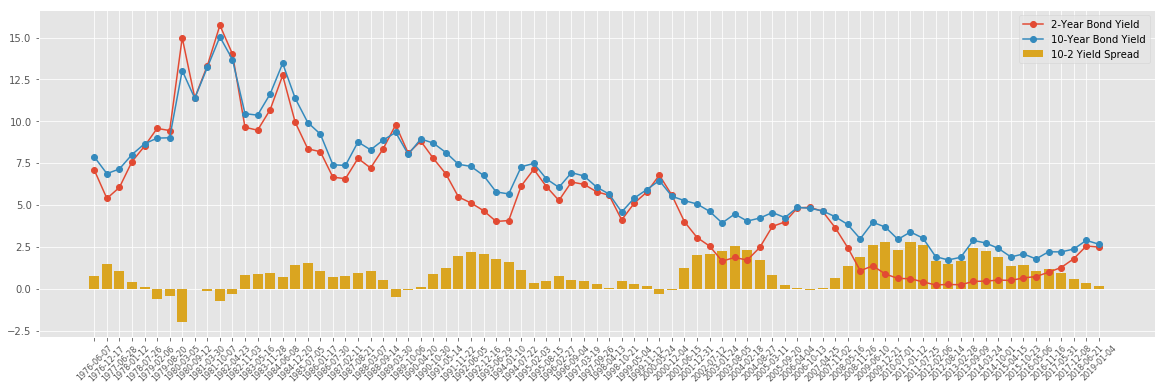

In [124]:
plot_yield(df, freq = 80, date_from = '1976-06-07', date_to = '2019-03-15')